# ***Section Clinical State Binary Classification***

This notebook shows the process of classification section samples into binary clinical state (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [13]:
# Define folder that contains the dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/section_classification_models"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 44000
# The MSI sample type for filtering
SAMPLE_TYPE = "section"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150

### ***Reading MSI clinical state anotations***

Next, let's read the clinical state anotations for each MSI:

In [3]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)

# Filter by sample_type
metadata_df = metadata_df[metadata_df.sample_type == SAMPLE_TYPE]

### ***Get all spectra's from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [4]:
# Create lists to store each spectra's info
sample_file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, msi_row in tqdm(metadata_df.iterrows(),
                           total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH,
                                f"{msi_row.sample_file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Keep sample file name of spectra
      sample_file_names.append(msi_row.sample_file_name)
      # Keep sample number of spectra
      sample_numbers.append(msi_row.sample_number)
      # Keep sample histology of spectra
      histologies.append(msi_row.histology)
      # Keep sample who grade of spectra
      who_grades.append(msi_row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)
        
# Convert to numpy array
sample_file_names = np.array(sample_file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [02:13<00:00,  5.56s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [5]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

In [6]:
mzs, _ =  parsers["HG 10-s"].getspectrum(0)
mzs_filter = (mzs >= 50) & (mzs < 600)

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [7]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = sample_file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra[mzs_filter], labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [14]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Leave one sample out classification:***

Next, let"s create a classification model for each leave one sample out option:

In [11]:
# Loop over each sample number
for exclude_image, group in tqdm(metadata_df.groupby("file_name")):
  exclude_samples = np.unique(sample_file_names[~np.isin(sample_numbers, group.sample_number.to_list())])
  print(exclude_samples)

100%|██████████| 8/8 [00:00<00:00, 170.67it/s]

['HG 10-s' 'HG 13-s' 'HG 14-s' 'HG 15-s' 'HG 16-s' 'HG 18-s' 'HG 19-s'
 'HG 2-s' 'HG 20-s' 'HG 21-s' 'HG 23-s' 'HG 25-s' 'HG 29-s' 'HG 3-s'
 'HG 4-s' 'HG 5-s' 'HG 6-s' 'HG 7-s' 'HG 8-s' 'HG 9-s']
['HG 10-s' 'HG 11_1-s' 'HG 11_2-s' 'HG 12-s' 'HG 12_1-s' 'HG 15-s'
 'HG 16-s' 'HG 18-s' 'HG 19-s' 'HG 2-s' 'HG 20-s' 'HG 21-s' 'HG 23-s'
 'HG 25-s' 'HG 29-s' 'HG 3-s' 'HG 4-s' 'HG 5-s' 'HG 6-s' 'HG 7-s' 'HG 8-s'
 'HG 9-s']
['HG 10-s' 'HG 11_1-s' 'HG 11_2-s' 'HG 12-s' 'HG 12_1-s' 'HG 13-s'
 'HG 14-s' 'HG 18-s' 'HG 19-s' 'HG 2-s' 'HG 20-s' 'HG 21-s' 'HG 23-s'
 'HG 25-s' 'HG 29-s' 'HG 3-s' 'HG 4-s' 'HG 5-s' 'HG 6-s' 'HG 7-s' 'HG 8-s'
 'HG 9-s']
['HG 10-s' 'HG 11_1-s' 'HG 11_2-s' 'HG 12-s' 'HG 12_1-s' 'HG 13-s'
 'HG 14-s' 'HG 15-s' 'HG 16-s' 'HG 2-s' 'HG 20-s' 'HG 21-s' 'HG 23-s'
 'HG 25-s' 'HG 29-s' 'HG 3-s' 'HG 4-s' 'HG 5-s' 'HG 6-s' 'HG 7-s' 'HG 8-s'
 'HG 9-s']
['HG 10-s' 'HG 11_1-s' 'HG 11_2-s' 'HG 12-s' 'HG 12_1-s' 'HG 13-s'
 'HG 14-s' 'HG 15-s' 'HG 16-s' 'HG 18-s' 'HG 19-s' 'HG 2-s' 'HG 3-s'

In [15]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_image, group in tqdm(metadata_df.groupby("file_name")):
  exclude_samples = np.unique(sample_file_names[np.isin(sample_numbers, group.sample_number.to_list())])
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = (~np.isin(sample_file_names, exclude_samples) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_image}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_binary_accuracy",
      mode="max",
      save_best_only=True)

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              verbose=1,
                                              patience=5,
                                              min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(optimizer,
                               loss=losses.BinaryCrossentropy(),
                               metrics=["binary_accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=train_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator)
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator)

  # Clean model for next iteration
  classification_model = None

  # Separate training 
  print("#" * 30)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
72/72 [==============================] - 22s 271ms/step - loss: 0.1887 - binary_accuracy: 0.9260 - val_loss: 0.7028 - val_binary_accuracy: 0.5665
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 11-11-12-s\assets
Epoch 2/100
72/72 [==============================] - 18s 251ms/step - loss: 0.0338 - binary_accuracy: 0.9882 - val_loss: 0.7374 - val_binary_accuracy: 0.5665
Epoch 3/100
72/72 [==============================] - 18s 254ms/step - loss: 0.0187 - binary_accuracy: 0.9936 - val_loss: 0.7233 - val_binary_accuracy: 0.5665
Epoch 4/100
72/72 [==============================] - 19s 258ms/step - loss: 0.0143 - binary_accuracy: 0.9949 - val_loss: 0.6688 - val_binary_accuracy: 0.5665
Epoch 5/100
72/72 [==============================] - 18s 245ms/step - loss: 0.0134 - binary_accuracy: 0.9953 - val_loss: 0.4973 - val_binary_accuracy: 0.6132
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification

 12%|█▎        | 1/8 [05:44<40:13, 344.82s/it]

##############################
Epoch 1/100
76/76 [==============================] - 24s 299ms/step - loss: 0.1833 - binary_accuracy: 0.9270 - val_loss: 0.6884 - val_binary_accuracy: 0.5886
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 14-13-s\assets
Epoch 2/100
76/76 [==============================] - 19s 249ms/step - loss: 0.0392 - binary_accuracy: 0.9860 - val_loss: 0.6764 - val_binary_accuracy: 0.5886
Epoch 3/100
76/76 [==============================] - 21s 279ms/step - loss: 0.0181 - binary_accuracy: 0.9936 - val_loss: 0.6224 - val_binary_accuracy: 0.5886
Epoch 4/100
76/76 [==============================] - 19s 245ms/step - loss: 0.0144 - binary_accuracy: 0.9950 - val_loss: 0.5580 - val_binary_accuracy: 0.7971
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 14-13-s\assets
Epoch 5/100
76/76 [==============================] - 20s 267ms/step - loss: 0.0130 - binary_acc

 25%|██▌       | 2/8 [13:07<40:15, 402.58s/it]

##############################
Epoch 1/100
78/78 [==============================] - 21s 259ms/step - loss: 0.1674 - binary_accuracy: 0.9379 - val_loss: 0.6469 - val_binary_accuracy: 0.6520
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 15-16-s\assets
Epoch 2/100
78/78 [==============================] - 21s 267ms/step - loss: 0.0315 - binary_accuracy: 0.9908 - val_loss: 0.6601 - val_binary_accuracy: 0.6520
Epoch 3/100
78/78 [==============================] - 22s 280ms/step - loss: 0.0178 - binary_accuracy: 0.9941 - val_loss: 0.6304 - val_binary_accuracy: 0.6520
Epoch 4/100
78/78 [==============================] - 21s 274ms/step - loss: 0.0112 - binary_accuracy: 0.9966 - val_loss: 0.5381 - val_binary_accuracy: 0.6522
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 15-16-s\assets
Epoch 5/100
78/78 [==============================] - 23s 292ms/step - loss: 0.0078 - binary_acc

 38%|███▊      | 3/8 [19:29<32:45, 393.07s/it]

##############################
Epoch 1/100
81/81 [==============================] - 23s 270ms/step - loss: 0.1748 - binary_accuracy: 0.9331 - val_loss: 0.6329 - val_binary_accuracy: 0.6762
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 19-18-s\assets
Epoch 2/100
81/81 [==============================] - 21s 260ms/step - loss: 0.0325 - binary_accuracy: 0.9891 - val_loss: 0.6218 - val_binary_accuracy: 0.6762
Epoch 3/100
81/81 [==============================] - 19s 234ms/step - loss: 0.0171 - binary_accuracy: 0.9947 - val_loss: 0.5925 - val_binary_accuracy: 0.6762
Epoch 4/100
81/81 [==============================] - 22s 268ms/step - loss: 0.0100 - binary_accuracy: 0.9965 - val_loss: 0.5248 - val_binary_accuracy: 0.7041
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 19-18-s\assets
Epoch 5/100
81/81 [==============================] - 20s 252ms/step - loss: 0.0090 - binary_acc

 50%|█████     | 4/8 [25:14<24:56, 374.09s/it]

##############################
Epoch 1/100
61/61 [==============================] - 17s 259ms/step - loss: 0.2525 - binary_accuracy: 0.8972 - val_loss: 0.4804 - val_binary_accuracy: 0.8139
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 29-25-23-21-20-s\assets
Epoch 2/100
61/61 [==============================] - 18s 301ms/step - loss: 0.0289 - binary_accuracy: 0.9912 - val_loss: 0.5347 - val_binary_accuracy: 0.8139
Epoch 3/100
61/61 [==============================] - 17s 272ms/step - loss: 0.0188 - binary_accuracy: 0.9948 - val_loss: 0.6061 - val_binary_accuracy: 0.8139
Epoch 4/100
61/61 [==============================] - 17s 275ms/step - loss: 0.0228 - binary_accuracy: 0.9930 - val_loss: 0.5924 - val_binary_accuracy: 0.8139
Epoch 5/100
61/61 [==============================] - 15s 244ms/step - loss: 0.0112 - binary_accuracy: 0.9969 - val_loss: 0.5779 - val_binary_accuracy: 0.8139
Epoch 6/100
61/61 [==============================

 62%|██████▎   | 5/8 [27:16<14:09, 283.08s/it]

##############################
Epoch 1/100
82/82 [==============================] - 24s 279ms/step - loss: 0.1846 - binary_accuracy: 0.9282 - val_loss: 0.6721 - val_binary_accuracy: 0.6185
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 6-7-s\assets
Epoch 2/100
82/82 [==============================] - 21s 249ms/step - loss: 0.0378 - binary_accuracy: 0.9870 - val_loss: 0.6801 - val_binary_accuracy: 0.6185
Epoch 3/100
82/82 [==============================] - 22s 261ms/step - loss: 0.0219 - binary_accuracy: 0.9923 - val_loss: 0.6401 - val_binary_accuracy: 0.6185
Epoch 4/100
82/82 [==============================] - 23s 285ms/step - loss: 0.0138 - binary_accuracy: 0.9955 - val_loss: 0.5310 - val_binary_accuracy: 0.6927
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 6-7-s\assets
Epoch 5/100
82/82 [==============================] - 22s 273ms/step - loss: 0.0103 - binary_accurac

 75%|███████▌  | 6/8 [33:14<10:17, 308.62s/it]

##############################
Epoch 1/100
62/62 [==============================] - 17s 255ms/step - loss: 0.1420 - binary_accuracy: 0.9440 - val_loss: 0.6973 - val_binary_accuracy: 0.5269
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 8-12-5-4-3-2-s\assets
Epoch 2/100
62/62 [==============================] - 15s 244ms/step - loss: 0.0279 - binary_accuracy: 0.9906 - val_loss: 0.6931 - val_binary_accuracy: 0.5269
Epoch 3/100
62/62 [==============================] - 17s 281ms/step - loss: 0.0180 - binary_accuracy: 0.9940 - val_loss: 0.6477 - val_binary_accuracy: 0.5269
Epoch 4/100
62/62 [==============================] - 16s 251ms/step - loss: 0.0130 - binary_accuracy: 0.9946 - val_loss: 0.5886 - val_binary_accuracy: 0.5333
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 8-12-5-4-3-2-s\assets
Epoch 5/100
62/62 [==============================] - 17s 265ms/step - loss: 0.014

 88%|████████▊ | 7/8 [38:33<05:12, 312.02s/it]

##############################
Epoch 1/100
81/81 [==============================] - 24s 282ms/step - loss: 0.1658 - binary_accuracy: 0.9355 - val_loss: 0.6704 - val_binary_accuracy: 0.6144
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 9-10-s\assets
Epoch 2/100
81/81 [==============================] - 22s 271ms/step - loss: 0.0323 - binary_accuracy: 0.9893 - val_loss: 0.6545 - val_binary_accuracy: 0.6144
Epoch 3/100
81/81 [==============================] - 21s 261ms/step - loss: 0.0194 - binary_accuracy: 0.9932 - val_loss: 0.6065 - val_binary_accuracy: 0.7379
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_HG 9-10-s\assets
Epoch 4/100
81/81 [==============================] - 23s 289ms/step - loss: 0.0129 - binary_accuracy: 0.9959 - val_loss: 0.5402 - val_binary_accuracy: 0.7253
Epoch 5/100
81/81 [==============================] - 23s 288ms/step - loss: 0.0101 - binary_accur

100%|██████████| 8/8 [46:55<00:00, 351.88s/it]

##############################


In [16]:
train_metrics

{'HG 11-11-12-s': [0.0003158029285259545, 1.0],
 'HG 14-13-s': [6.531235703732818e-05, 1.0],
 'HG 15-16-s': [3.269732042099349e-05, 1.0],
 'HG 19-18-s': [0.0005053688073530793, 1.0],
 'HG 29-25-23-21-20-s': [0.480465292930603, 0.8138709664344788],
 'HG 6-7-s': [0.004238723777234554, 0.9999040961265564],
 'HG 8-12-5-4-3-2-s': [2.2088479454396293e-05, 1.0],
 'HG 9-10-s': [1.333606087428052e-05, 1.0]}

In [17]:
validation_metrics

{'HG 11-11-12-s': [0.009486493654549122, 0.9969505667686462],
 'HG 14-13-s': [0.009504089131951332, 0.9975181221961975],
 'HG 15-16-s': [0.003170360578224063, 0.998389720916748],
 'HG 19-18-s': [0.0069066560827195644, 0.9976621866226196],
 'HG 29-25-23-21-20-s': [0.4803897440433502, 0.8139354586601257],
 'HG 6-7-s': [0.013480433262884617, 0.9967389106750488],
 'HG 8-12-5-4-3-2-s': [0.008070552721619606, 0.9982147216796875],
 'HG 9-10-s': [0.0056021385826170444, 0.9982551336288452]}

### ***Leave one sample out classification evaluation - tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [18]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_file_names == row.sample_file_name) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [01:29<00:00,  3.71s/it]


Next, let's get some statistics about each left out sample predictions:

In [19]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.3353268802,0.9999402761,0.9960278273,0.9776566029,0.0640212446,1,1
1,HG 11_2-s,0.2641886771,0.9999539852,0.9971990585,0.9733603001,0.0749573559,1,1
2,HG 12-s,0.6458691955,1.0000000000,0.9993163347,0.9943404198,0.0214690343,1,1
3,HG 14-s,0.0000000003,0.9999955893,0.6859877110,0.5687187314,0.3899511397,1,1
4,HG 13-s,0.0000000002,0.9993990660,0.0409669168,0.2503154874,0.3361017406,1,0
5,HG 15-s,0.0000000000,0.9999998808,0.1136305556,0.4465517700,0.4715968966,1,0
6,HG 16-s,0.0000000000,0.9652987123,0.0000019580,0.0082867015,0.0606001504,0,0
7,HG 19-s,0.9983564019,0.9997850060,0.9993554950,0.9993298054,0.0001791613,0,1
8,HG 18-s,0.9973801970,0.9997348189,0.9994736314,0.9993791580,0.0002704971,0,1
9,HG 29-s,0.8037011027,0.8043376803,0.8039224744,0.8039426804,0.0001148933,0,1


Next, let's evaluate the classification performance:

In [20]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.375
Balanced  Accuracy: 0.344
Precision: 0.538
Recall: 0.438
F1 score: 0.483


Next, let's plot the roc curve:

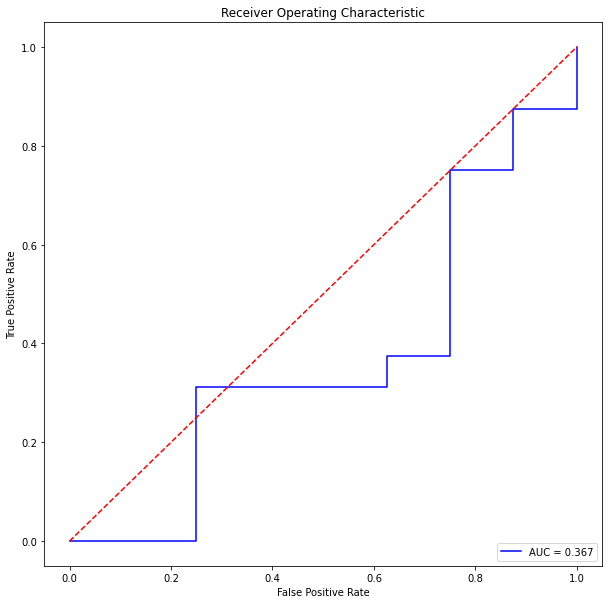

In [21]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

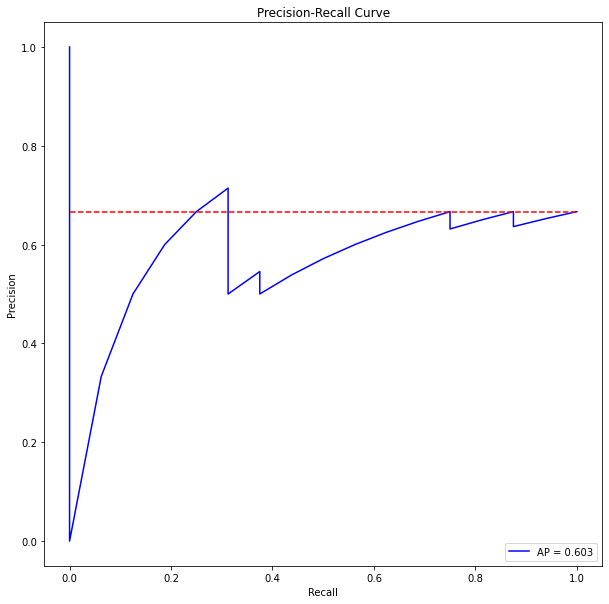

In [22]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

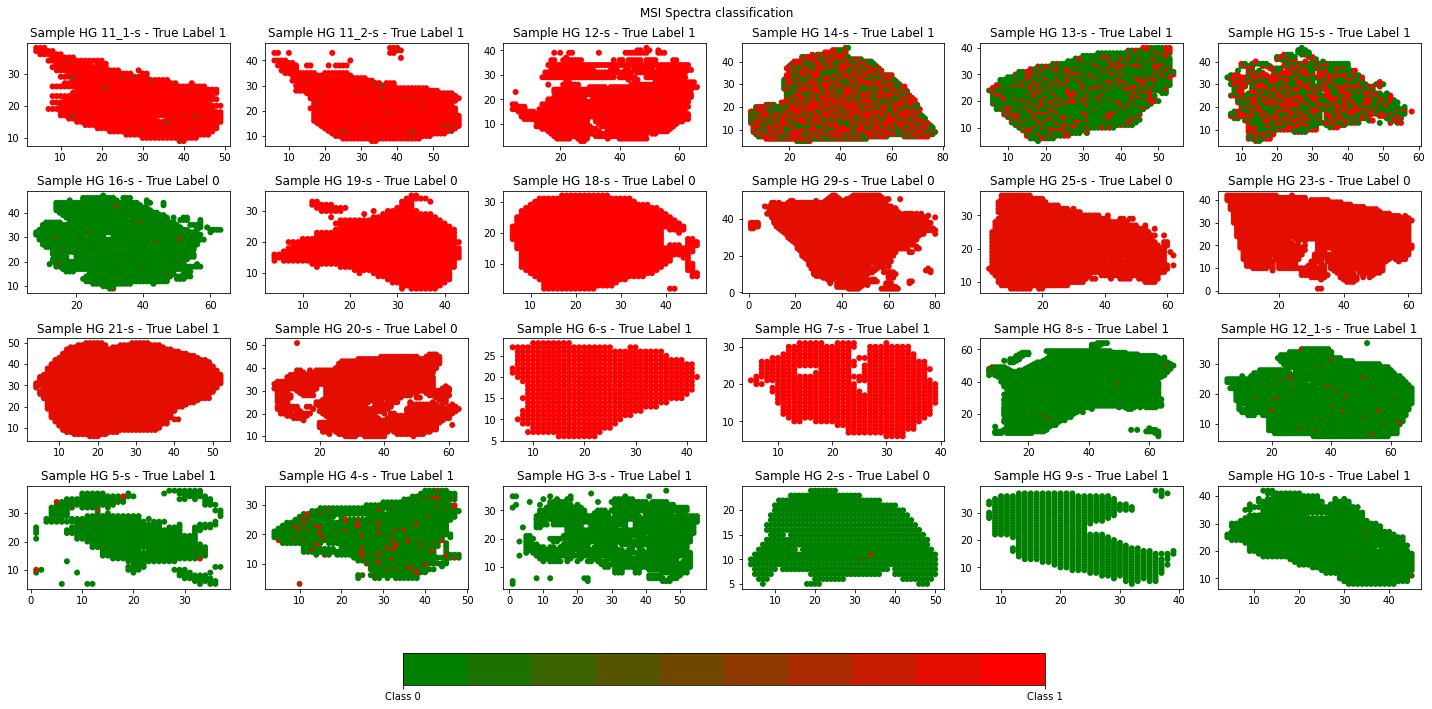

In [24]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_file_names == key) & is_tissue],
                  y_coordinates[(sample_file_names == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Leave one sample out classification evaluation - non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [25]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_file_names == row.sample_file_name) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


Next, let's get some statistics about each left out sample predictions:

In [26]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.4852916598,0.9999949932,0.9996616840,0.9973673820,0.0182787534,1,1
1,HG 11_2-s,0.4797350168,0.9999935627,0.9998909831,0.9986539483,0.0166505333,1,1
2,HG 12-s,0.9028790593,0.9999992847,0.9998445511,0.9987143278,0.0044541773,1,1
3,HG 14-s,0.0000000000,0.9990195036,0.0000000573,0.0056394357,0.0676320270,1,0
4,HG 13-s,0.0000000000,0.7475460768,0.0000001371,0.0025519135,0.0334910415,1,0
5,HG 15-s,0.0000000000,0.0060549132,0.0000000131,0.0000073602,0.0001565271,1,0
6,HG 16-s,0.0000000000,0.0015580560,0.0000000542,0.0000090237,0.0000652333,0,0
7,HG 19-s,0.9984742999,0.9999821186,0.9998861551,0.9998375177,0.0001293742,0,1
8,HG 18-s,0.9985588193,0.9999899864,0.9998626709,0.9998190403,0.0001359401,0,1
9,HG 29-s,0.8040987253,0.8044242263,0.8042985797,0.8042945862,0.0000504623,0,1


Next, let's evaluate the classification performance:

In [27]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.333
Balanced  Accuracy: 0.312
Precision: 0.500
Recall: 0.375
F1 score: 0.429


Next, let's plot the roc curve:

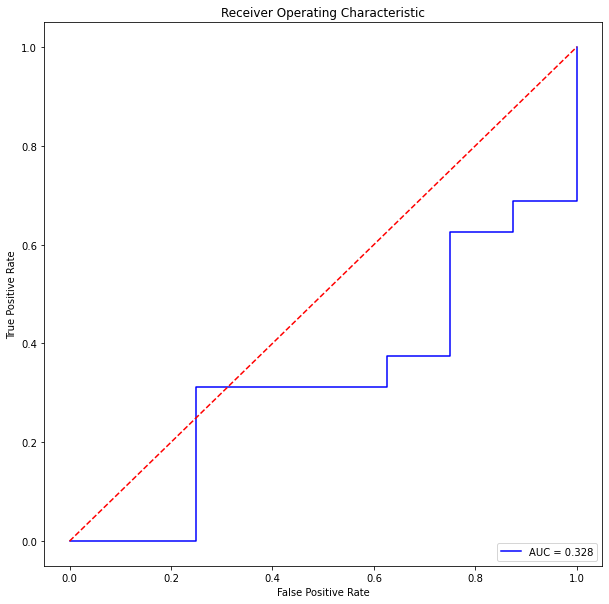

In [28]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

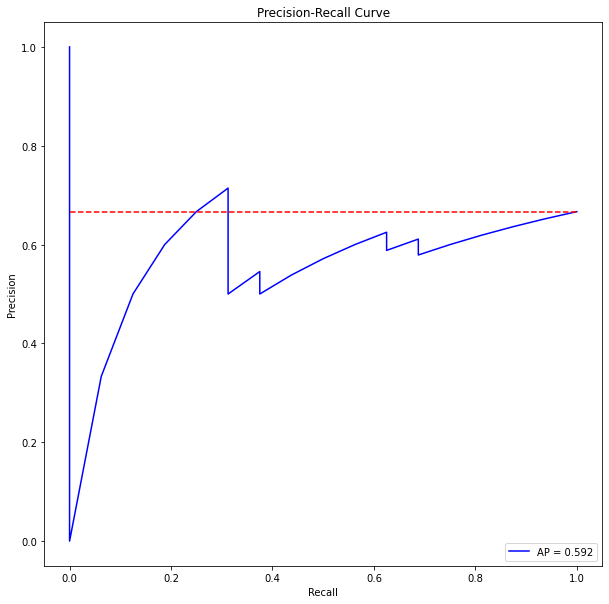

In [29]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

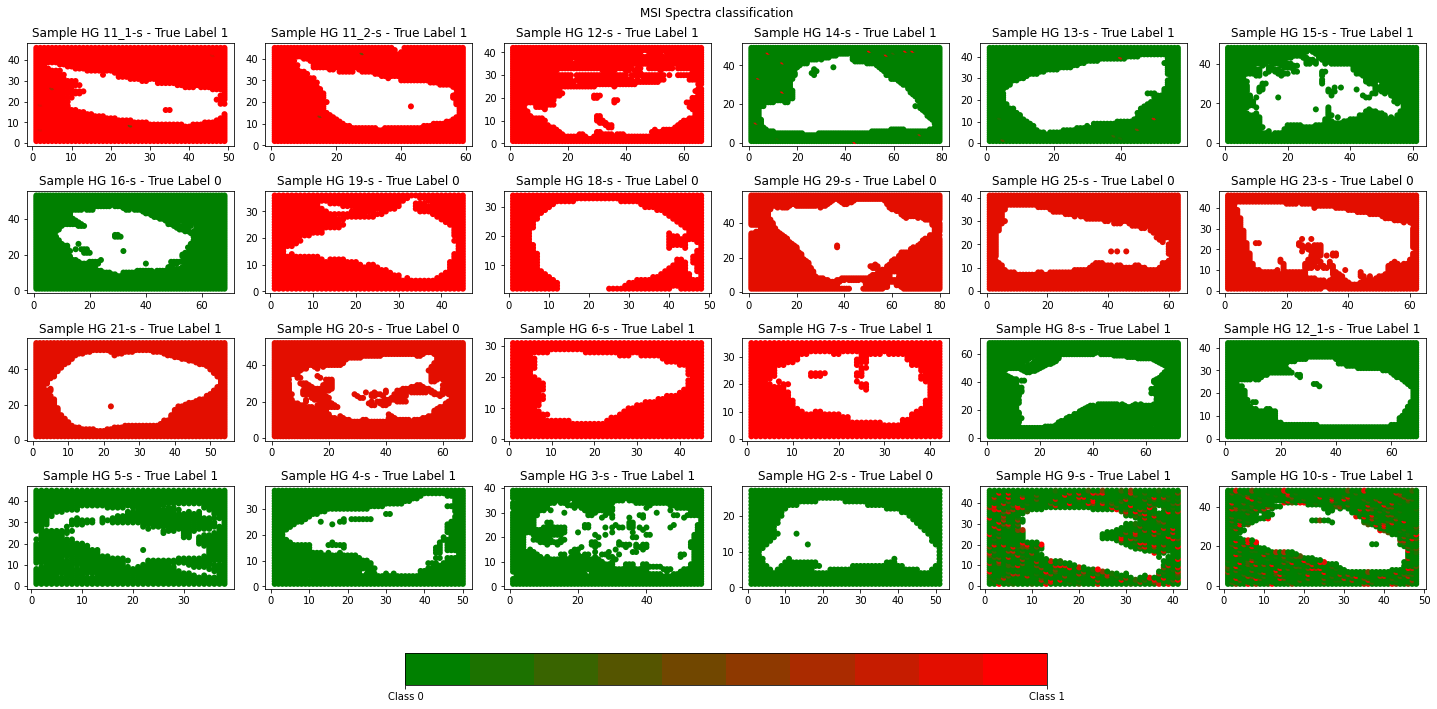

In [32]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_file_names == key) & ~is_tissue],
                  y_coordinates[(sample_file_names == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [23]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()